# Titanic Data Mining Lesson: Evaluating a Random Forest Model

In this lesson, you will evaluate the performance of a Random Forest classifier on the Titanic dataset. The goal is to understand key evaluation metrics: **confusion matrix**, **accuracy**, **precision**, **recall**, **F1 score**, and **AUC**.

## Step 1: Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

## Step 2: Load and Prepare Titanic Data

In [2]:
# Load Titanic dataset
df = sns.load_dataset("titanic").dropna(subset=['age', 'embarked', 'sex'])

# Encode categorical variables
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['embarked'] = df['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Features and target
X = df[['pclass', 'age', 'sex', 'fare', 'embarked']]
y = df['survived']

## Step 3: Split the Data and Train the Model

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_probs = rf.predict_proba(X_test)[:, 1]

## Step 4: Evaluate the Model

We will now look at several evaluation metrics and interpret them.
<p>Precision: Of all of the passengers we said would survive (or not), how many actually did?</p>
<p>Recall: Of all passengers who actually survived, how many did we correctly predict?</p>
<p>F1 Score: F1 Score tells you how well your model balances catching survivors (Recall) with not falsely assuming people survived (Precision).</p>
<p>Example:<br>
Imagine you're trying to predict who survived the Titanic:<br>

Precision = 0.8 → Of all people predicted to survive, 80% actually did.<br>

Recall = 0.6 → Of all people who actually survived, you found 60%.<br>
Accuracy: How often the model is right overall.<br></p>


In [19]:
# Confusion matrix and classification report
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print labeled confusion matrix
print("Confusion Matrix:")
print("               Predicted")
print("              0        1")
print("Actual 0   {:<8} {:<8}".format(cm[0, 0], cm[0, 1]))
print("Actual 1   {:<8} {:<8}".format(cm[1, 0], cm[1, 1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_probs))

Confusion Matrix:
               Predicted
              0        1
Actual 0   77       10      
Actual 1   21       35      

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.83        87
           1       0.78      0.62      0.69        56

    accuracy                           0.78       143
   macro avg       0.78      0.76      0.76       143
weighted avg       0.78      0.78      0.78       143

AUC Score: 0.7831486042692939


## Step 5: Plot the ROC Curve

## 🧠 What is the ROC Curve?

The **ROC Curve** (Receiver Operating Characteristic curve) is a graph that shows how well your model **separates** the two classes—like survivors vs. non-survivors.

---

### 📊 What’s on the axes?
- **X-axis**: False Positive Rate  
  (bad predictions where the model says “survived” but the person didn’t)
- **Y-axis**: True Positive Rate = **Recall**  
  (how many actual survivors the model correctly found)

---

### 💡 How it works:
The ROC curve shows how the model performs at **different thresholds** (cut-off points for saying “yes” or “no”).

> The curve starts in the bottom left (0,0) and moves toward the top right (1,1).  
> The **better the model**, the closer the curve hugs the **top-left corner**.

---

### 🏆 What is AUC?
- **AUC** = Area Under the Curve
- It’s a number between **0 and 1**
- **Closer to 1** = better model
- **0.5** = no better than guessing

---

### 🐳 Easy Analogy:
> Imagine a shark detector. The ROC curve tells you how well it can  
> **catch real sharks (true positives)** without mistaking  
> **dolphins for sharks (false positives).**

---

### 📌 Bottom Line:
> **The ROC curve helps you visualize how good your model is at telling one class from the other—especially when you change the decision threshold. A curve that bows up toward the top-left is what you want.**

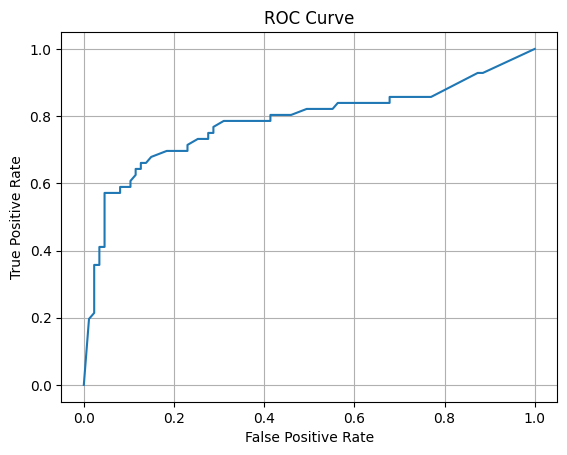

In [8]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

## 🧠 Step 6: Explainability - Partial Dependence Plots (XAI)

Partial Dependence Plots (PDPs) show how each feature (like age, fare, and sex) affects the model's prediction while averaging out the effects of other features. This helps us understand which variables influence survival predictions the most.

In [9]:
from sklearn.inspection import PartialDependenceDisplay

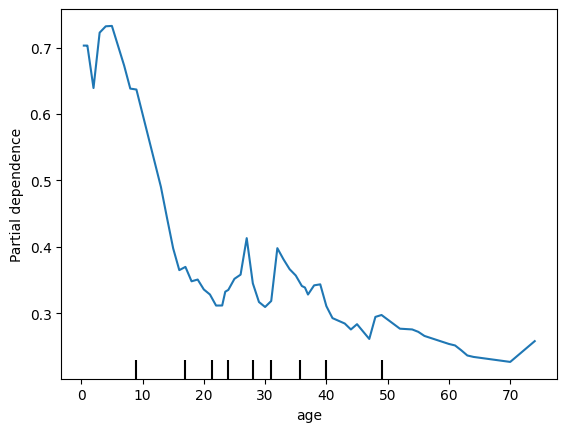

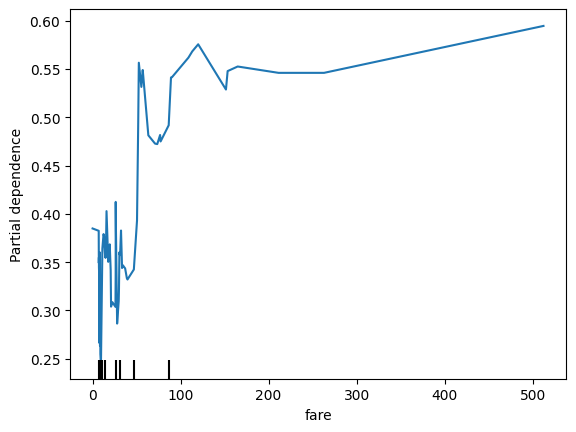

In [10]:
# Partial Dependence Plots (XAI)
PartialDependenceDisplay.from_estimator(rf, X_test, ['age'])
plt.show()
#
PartialDependenceDisplay.from_estimator(rf, X_test, ['fare'])
plt.show()

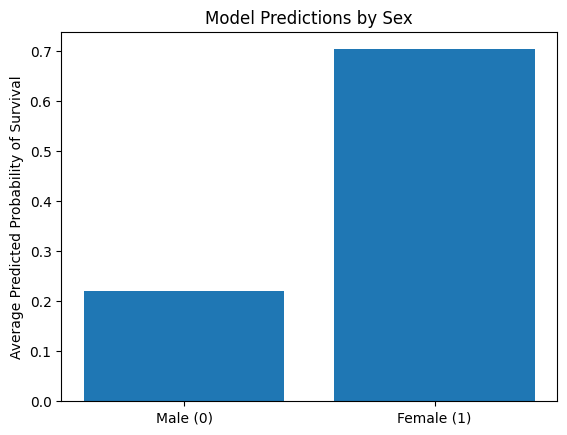

In [11]:
# Another way to explain results
# binary features sometimes cause issues with PDP
# Group by 'sex' and calculate average prediction
X_test_with_probs = X_test.copy()
X_test_with_probs['predicted_prob'] = rf.predict_proba(X_test)[:, 1]
X_test_with_probs['sex'] = X_test_with_probs['sex'].astype(int)

sex_means = X_test_with_probs.groupby('sex')['predicted_prob'].mean()

# Plot
plt.bar(['Male (0)', 'Female (1)'], sex_means)
plt.ylabel('Average Predicted Probability of Survival')
plt.title('Model Predictions by Sex')
plt.show()

## #**Answers**

###1) define the new target

In [14]:
# Split fare into 3 quantile-based levels
df['fare_level'] = pd.qcut(df['fare'], q=3, labels=['low', 'medium', 'high'])

# Encode the new categorical target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['fare_level_encoded'] = le.fit_transform(df['fare_level'])
# New target for modeling
y_new = df['fare_level_encoded']


###2) reuse or modify the feature set x

In [15]:
# Remove 'fare' from features since it's now the target variable
X_new = df[['pclass', 'age', 'sex', 'embarked']]


###3) train and evaluate a new Random Forest Model

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Split data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.2, random_state=44
)

# Train model
rf_new = RandomForestClassifier(random_state=42)
rf_new.fit(X_train_new, y_train_new)

# Evaluate
y_pred_new = rf_new.predict(X_test_new)
accuracy_new = accuracy_score(y_test_new, y_pred_new)
conf_matrix_new = confusion_matrix(y_test_new, y_pred_new)
report_new = classification_report(y_test_new, y_pred_new)
feature_importance_new = rf_new.feature_importances_


In [21]:
# Print model evaluation metrics for the new target

print(f"Accuracy: {accuracy_new:.4f}")
print("Confusion Matrix:")
print(conf_matrix_new)
print("Classification Report:")
print(report_new)


Accuracy: 0.6853
Confusion Matrix:
[[33  1 16]
 [ 3 44  5]
 [12  8 21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67        50
           1       0.83      0.85      0.84        52
           2       0.50      0.51      0.51        41

    accuracy                           0.69       143
   macro avg       0.67      0.67      0.67       143
weighted avg       0.69      0.69      0.69       143



##plotting ROC curve

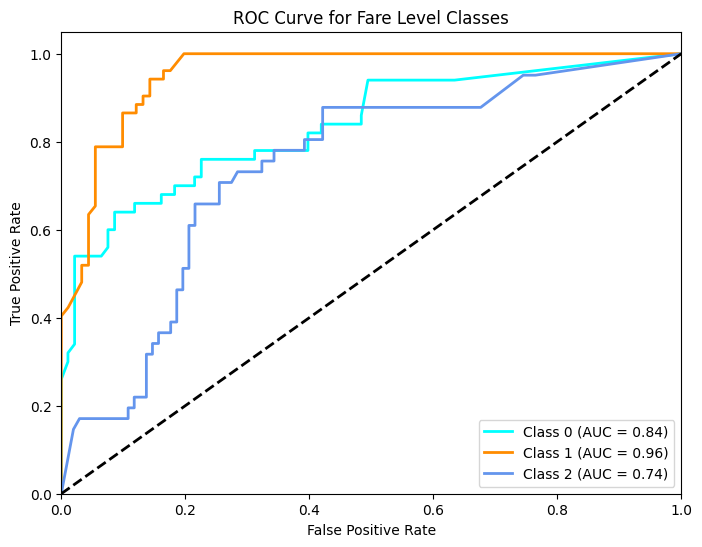

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize the targets for multiclass ROC
classes = np.unique(y_new)
y_test_bin = label_binarize(y_test_new, classes=classes)
y_score = rf_new.predict_proba(X_test_new)

plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(classes)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fare Level Classes')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix Heatmap

Reveals which fare levels are often confused by the model, useful for model diagnostics.

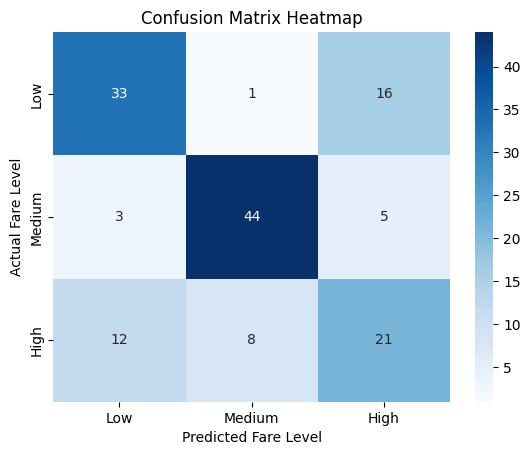

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_new, y_pred_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted Fare Level')
plt.ylabel('Actual Fare Level')
plt.title('Confusion Matrix Heatmap')
plt.show()


#What do you notice about accuracy, feature importance, or confusion matrix?



## Model Results Comparison: Survival vs Fare Level Prediction

### 1. Random Forest Model Results — Predicting Survival

**Accuracy:**  
0.7832

**Confusion Matrix:**

|          | Predicted 0 | Predicted 1 |
|----------|-------------|-------------|
| Actual 0 |      77     |     10      |
| Actual 1 |      21     |     35      |

**Classification Report:**

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     |   0.79    | 0.89   |  0.83    |   87    |
| 1     |   0.78    | 0.62   |  0.69    |   56    |
| **Accuracy** |       |        |  0.78    |   143   |
| **Macro avg** | 0.78 | 0.76   |  0.76    |   143   |
| **Weighted avg** | 0.78 | 0.78   |  0.78    |   143   |

**AUC Score:**  
0.7831

---

### 2. Random Forest Model Results — Predicting Fare Level

**Accuracy:**  
0.6853

**Confusion Matrix:**

|          | Predicted 0 | Predicted 1 | Predicted 2 |
|----------|-------------|-------------|-------------|
| Actual 0 |     33      |      1      |     16      |
| Actual 1 |      3      |     44      |      5      |
| Actual 2 |     12      |      8      |     21      |

**Classification Report:**

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     |  0.69     | 0.66   |  0.67    |   50    |
| 1     |  0.83     | 0.85   |  0.84    |   52    |
| 2     |  0.50     | 0.51   |  0.51    |   41    |
| **Accuracy** |        |        |  0.69    |  143    |
| **Macro avg** | 0.67  | 0.67   |  0.67    |  143    |
| **Weighted avg** | 0.69 | 0.69   |  0.69    |  143    |

---

### 3. Observations

- **Accuracy:** The survival model outperforms the fare level model (0.78 vs 0.69).
- **Confusion Matrix:** The survival model shows stronger true positive rates and fewer misclassifications. The fare level model performs best on the 'medium' fare class but confuses 'low' and 'high' classes.
- **Classification Metrics:** The survival model demonstrates a better balance between precision and recall, while the fare level model struggles with minority classes.
- **AUC (for survival):** 0.78, further confirming robust classification for survival prediction.

---




### 4. Conclusion: Which Model Is Better?

- **The survival prediction model is better**, with higher accuracy, more balanced classification metrics, and stronger confusion matrix results.
- The fare level model struggles to differentiate between low and high fare groups, likely because these classes are less clearly separated by the chosen features.
- **Survival prediction** is more reliable and practical for this dataset, especially with features like fare and age being strong predictors of outcome.

## Discussion Questions
- What do the values in the confusion matrix represent?
- If our goal is to **save as many lives as possible**, should we prioritize **precision** or **recall**?
- Can a model have high **accuracy** but still perform poorly?
- How does the **AUC** help us understand the model's performance?